In [1]:
import os
import numpy as np
from random import sample, seed
from tqdm import tqdm
import tensorflow as tf 
tf.autograph.set_verbosity(0)
os.environ['AUTOGRAPH_VERBOSITY'] = "0"
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Flatten, Reshape, Input, BatchNormalization, GlobalAveragePooling3D, Dropout
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from utils.layers import *

In [2]:
def _buildEncoder(input_shape, filters=[16, 32, 64, 128], last_activation=relu):
    
    input = Input(shape=input_shape)
    x = Conv3D(filters=filters[0], kernel_size=5, strides=(2,2,2), padding="SAME")(input)
    x = BatchNormalization()(x)
    x = relu(x)
    for i, ft in enumerate(filters[1:]):
        if i == len(filters[1:])-1:
            x = residual_block(x, filters = ft, kernel_size= 3,  
                        strides = (2,2,2), padding = "SAME", activate=relu)
        else:
            x = residual_block(x, filters = ft, kernel_size= 3,  
                        strides = (2,2,2), padding = "SAME", activate=last_activation)
    
    encoder = Model(inputs=input, outputs=x)        
    return encoder

In [3]:
encoder = _buildEncoder([48,96,96,1], filters=[16, 32, 64, 128])

In [4]:
a = tf.ones(shape=[8,15,60,60,1], dtype=tf.float32)
b = encoder(a[slice(None)])
b.shape
shape=encoder.output_shape
print(shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(None, 3, 6, 6, 128)


In [5]:
def _buildDecoder(input_shape, filters=[16, 32, 64, 128], last_activation=relu, **kwargs):
    input = Input(shape=input_shape)
    x = input
    for i, ft in enumerate(filters[-1:0:-1]):
        if i != len(filters[-2::-1])-1:
            x = resTP_block(x, filters=ft, strides=(2,2,2),padding="SAME")
        else:
            x = resTP_block(x, filters=ft, strides=(2,2,2),padding="SAME", activation="relu")
    
    x = Conv3DTranspose(filters=filters[0], kernel_size=3, strides=(2,)*3, padding="SAME", activation="relu")(x)
    x = BatchNormalization()(x)
    
    if "slices" in kwargs:
        slices = kwargs["slices"]
        x = x[slices]

    x = Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation=last_activation)(x)
    decoder = Model(inputs=input, outputs=x)
    return decoder

In [8]:
encoder.output_shape
slices= [slice(None), slice(None,15), slice(2,62), slice(2,62), slice(None)]
slices=slice(None)

In [9]:
decoder = _buildDecoder(shape[1:], slices=slices)

In [10]:
print(encoder.input_shape)
print(encoder.output_shape)
print(decoder.input_shape)
print(decoder.output_shape)

(None, 48, 96, 96, 1)
(None, 3, 6, 6, 128)
(None, 3, 6, 6, 128)
(None, 48, 96, 96, 1)


In [ ]:
plot_model(encoder, show_shapes=True, to_file='resEncoder.png')
plot_model(decoder, show_shapes=True, to_file='resDecoder.png')

input = Input(shape=encoder.input_shape[1:])
ae = Model(input, decoder(encoder(input)))
plot_model(ae, show_shapes=True, to_file='resAE.png')

In [12]:
def _buildDiscriminator(input_shape, filters=[16, 32, 64, 128], last_activation=relu):

    input = Input(shape=input_shape)
    x = Conv3D(filters=filters[0], kernel_size=5, strides=(2,2,2), padding="SAME")(input)
    x = BatchNormalization()(x)
    x = relu(x)
    for i, ft in enumerate(filters[1:]):
        if i == len(filters[1:])-1:
            x = residual_block(x, filters = ft, kernel_size= 3,  
                        strides = (2,2,2), padding = "SAME", activate=relu)
        else:
            x = residual_block(x, filters = ft, kernel_size= 3,  
                        strides = (2,2,2), padding = "SAME", activate=last_activation)

    x = GlobalAveragePooling3D()(x)
    x = Flatten()(x)
    x = Dense(128, activation=relu)(x)
    x = Dropout(0.7)(x)
    x = Dense(128, activation=relu)(x)
    x = Dropout(0.7)(x)
    x = Dense(1, activation=sigmoid)(x)
    discriminator = Model(inputs=input, outputs=x) 

    return discriminator

In [13]:
ds = _buildDiscriminator([15, 60, 60, 1])

In [15]:
ds(tf.ones(shape=(12, 60, 60, 1)))

<tf.Tensor: shape=(12, 1), dtype=float32, numpy=
array([[0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788],
       [0.5034788]], dtype=float32)>

In [1]:
from model.resAAE import resAAE

config={
    "optG_lr":0.0002,
    "optG_beta":0.5,
    "optD_lr":0.0001,
    "optD_beta":0.5,
    "optAE_lr":0.001,
    "optAE_beta":0.9,
    "img_shape": (48, 96, 96, 1), 
    "encoded_dim": 16, 
    "loss": "mse", 
    "acc": "mse",
    "hidden": (16, 32, 64, 128),
    "output_slices": slice(None),
    "batch_size": 16,
    "epochs": 5000
}

model = resAAE(**config)

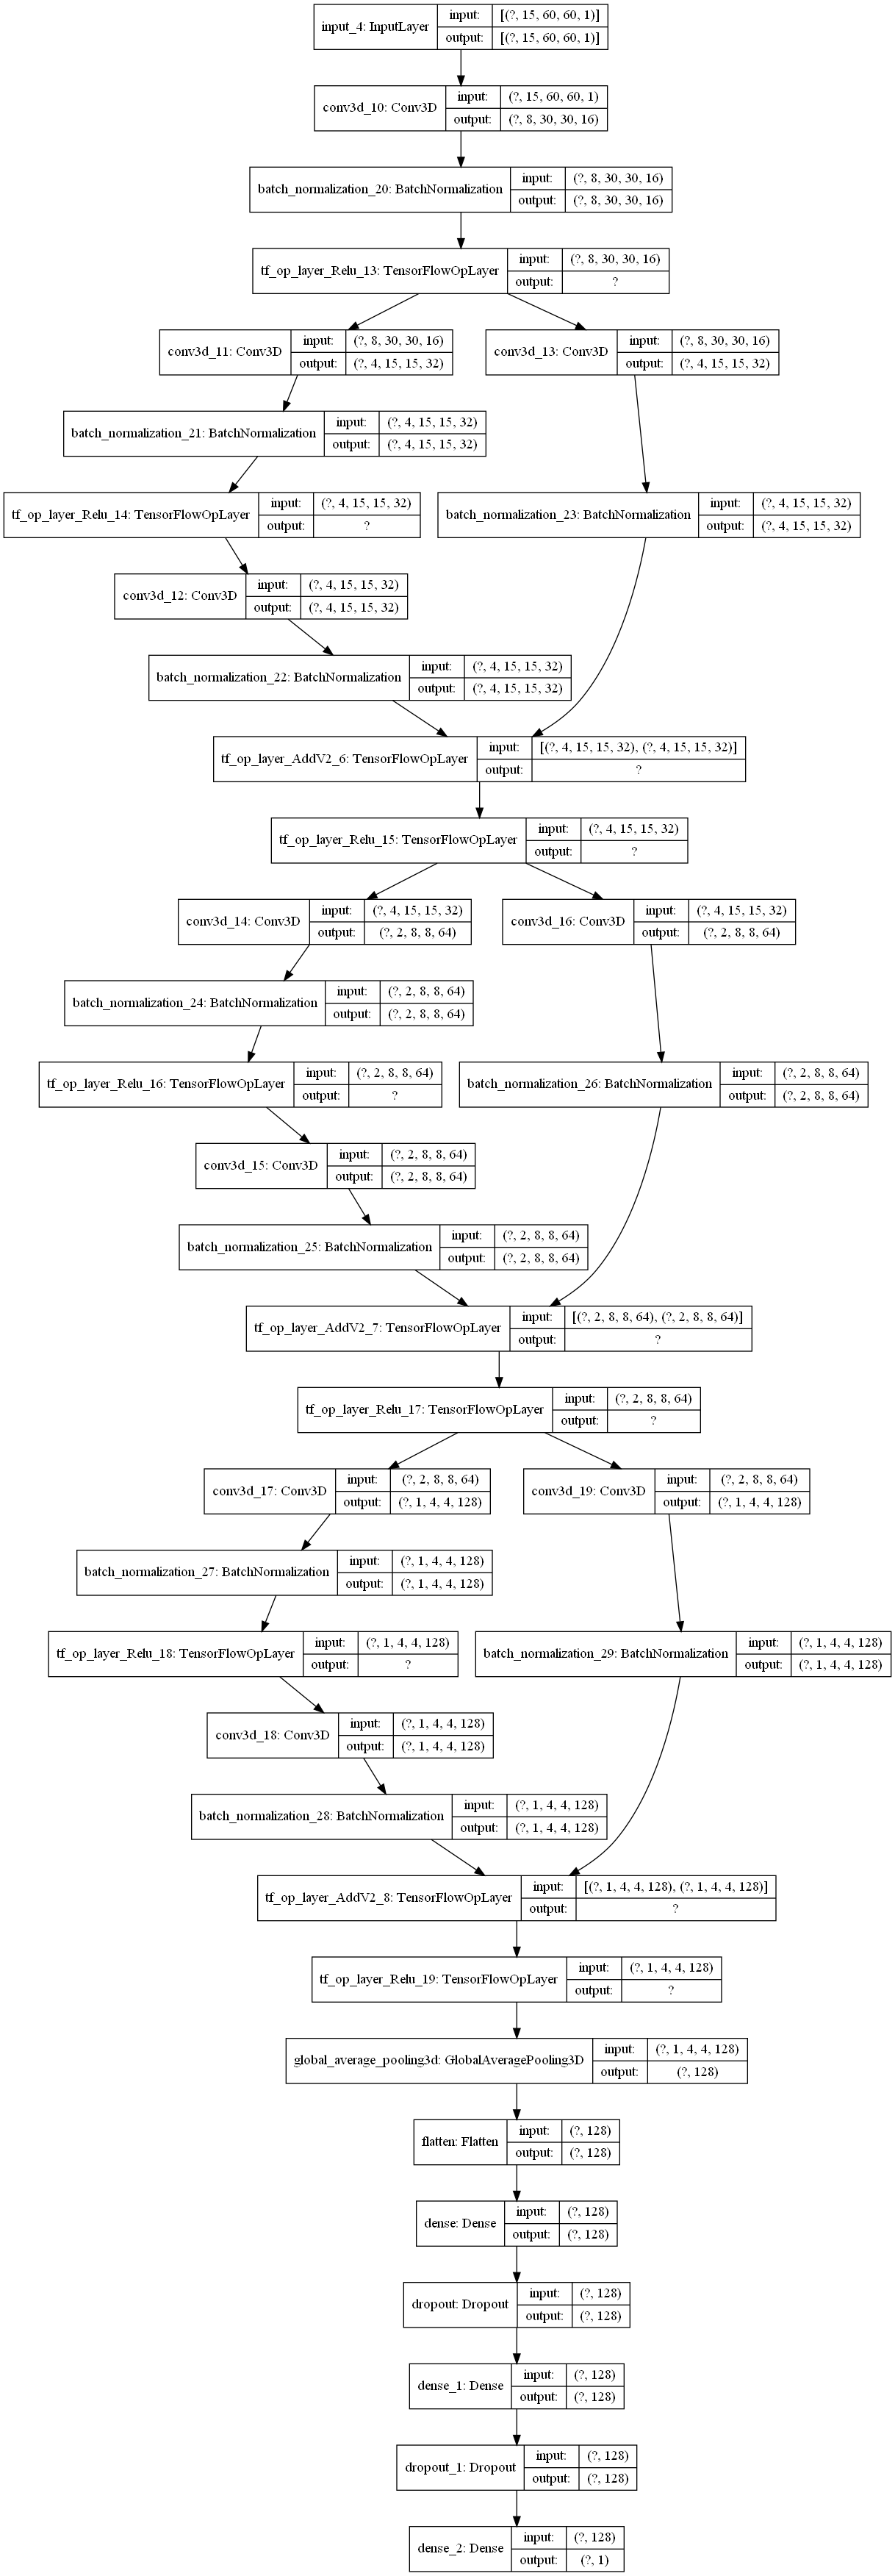

In [4]:
plot_model(model.encoder, show_shapes=True, to_file='resEncoder.png')
plot_model(model.decoder, show_shapes=True, to_file='resDecoder.png')
plot_model(model.autoencoder, show_shapes=True, to_file='resAE.png')
plot_model(model.discriminator, show_shapes=True, to_file='resDiscriminator.png')